## BOAR with Transfer Matrix Method
Version 1.0.0
(c) Vincent M. Le Corre, Larry Lueer, i-MEET 2021-2023

This notebook is made to use BOAR in combination with transfer matrix modeling (TMM) to optimize the thickness of the layers in a multilayer stack to optimize the average visible transmittance (AVT) and maximize the current density (Jsc) of a solar cell.  
To perform the transfer matrix modeling we use a modified version of the open-source program devoloped by [McGehee's group](https://web.stanford.edu/group/mcgehee/transfermatrix/) (Stanford University) and adapted to python by Kamil Mielczarek (University of Texas).  
For more information about the transfer matrix modeling, please refer to the [original paper](https://doi.org/10.1002/adma.201000883).

In [1]:
# Activate matplotlib widgets
# %matplotlib inline
# comment the next line if you are on the jupyterhub server
# %matplotlib widget 
# %matplotlib notebook
import plotly.io as pio # comment out to only render png
pio.renderers.default = 'png'

# Import libraries
import sys,os,types
import warnings
warnings.filterwarnings('ignore') # comment this out to see warnings

# Import boar
sys.path.append('../') # comment out if the Notebook is in the Notebooks folder
from boar import *
from boar.core.optimization_botorch import *
# import additional libraries from Ax
from ax.utils.notebook.plotting import render, init_notebook_plotting # for plotting in notebook
from ax.plot.slice import plot_slice
from ax.plot.scatter import interact_fitted,plot_objective_vs_constraints,tile_fitted
from ax.modelbridge.cross_validation import cross_validate
from ax.plot.contour import interact_contour
from ax.plot.diagnostic import interact_cross_validation
from ax.plot.pareto_utils import compute_posterior_pareto_frontier
from ax.plot.pareto_frontier import plot_pareto_frontier
# Import homemade package by VLC
# import boar.SIMsalabim_utils.plot_settings_screen # to set default plot settings


In [2]:
# Define the path to the data 
curr_dir = os.getcwd() # current directory
res_dir = os.path.join(os.path.abspath('../'),'temp') # path to the results directory
mat_dir = os.path.join(os.path.abspath('../'),'Example_Data/matdata') # path to the mat files directory, comment if not in Notebooks folder

In [3]:
# Initialize the agent and default device stack
layers 			= ['SiOx' , 'ITO' , 'ZnO' , 'PCE10_FOIC_1to1' , 'MoOx' , 'Ag', 'MoOx', 'LiF','MoOx', 'LiF','Air'] # list of layers (need to be the same than the name nk_*.csv file in the matdata folder)
thicknesses		= [0 , 100 , 30  , 100 , 9 , 8, 100, 100, 100, 100, 100] # list of thicknesses in nm
        
tm = Transfer_Matrix_agent(layers=layers, thicknesses=thicknesses,mat_dir=mat_dir) # initialize the agent

# Define the free parameters to be optimized

In this notebook, we not only optimize the thickness of the different layers in the stack, but also the material composition of the absorber layer by optimizing the nk values selected by the parameter nk_3.  
This can be done by passing a list of names of the materials to the parameter nk_3 in the lims attribute and by choosing the value_type of the FitParam object as 'str'. We also limit the resolution of the thickness to 1 nm by optimizing the thicknesses values as integers (value_type='int').

In [4]:
params = []
d_3 = Fitparam(name = 'd_3', val =  80, lims = [40, 200], relRange = 1, range_type = 'lin',
            lim_type = 'absolute',optim_type='lin', display_name = 'AL thickness', unit = 'nm',val_type='int')
params.append(d_3)
d_4 = Fitparam(name = 'd_4', val =  100, lims = [0, 200], relRange = 1, range_type = 'lin',
            lim_type = 'absolute',optim_type='lin', display_name = 'MoOx 1 thickness', unit = 'nm',val_type='int')
params.append(d_4)
d_5 = Fitparam(name = 'd_5', val =  10, lims = [0, 15], relRange = 1, range_type = 'lin',
            lim_type = 'absolute',optim_type='lin', display_name = 'Ag thickness', unit = 'nm',val_type='int')
params.append(d_5)
d_6 = Fitparam(name = 'd_6', val =  100, lims = [0, 200], relRange = 1, range_type = 'lin',
            lim_type = 'absolute',optim_type='lin', display_name = 'MoOx 2 thickness', unit = 'nm',val_type='int')
params.append(d_6)
d_7 = Fitparam(name = 'd_7', val =  10, lims = [0, 200], relRange = 1, range_type = 'lin',
            lim_type = 'absolute',optim_type='lin', display_name = 'LiF 1 thickness', unit = 'nm',val_type='int')
params.append(d_7)  
d_8 = Fitparam(name = 'd_8', val =  100, lims = [0, 200], relRange = 1, range_type = 'lin',
            lim_type = 'absolute',optim_type='lin', display_name = 'MoOx 3 thickness', unit = 'nm',val_type='int')
params.append(d_8)
d_9 = Fitparam(name = 'd_9', val =  10, lims = [0, 200], relRange = 0, range_type = 'lin',
            lim_type = 'absolute',optim_type='lin', display_name = 'LiF 2 thickness', unit = 'nm',val_type='int')
params.append(d_9)
nk_3 = Fitparam(name = 'nk_3', val =  'PCE10_FOIC_1to1', lims = ['PCE10_FOIC_1to1','P3HTPCBM_BHJ','PM6Y6Brabec'], relRange = 0.5, range_type = 'lin',
            lim_type = 'absolute',optim_type='lin', display_name = 'AL nk', unit = '',val_type='str')
params.append(nk_3)

In [5]:
# run the model on the default stack configuration
X = [0] # we need to provide a list of inputs even if it is not used later

print('Jsc = ', tm.TM(X,params,output=['Jsc'],is_MOO=False))
print('LUE = ', tm.TM(X,params,output=['LUE'],is_MOO=False))
print('AVT = ', tm.TM(X,params,output=['AVT'],is_MOO=False))

Jsc =  10.53248308747983
LUE =  3.5542800166757664
AVT =  0.337458886679895


# Start the optimization

Here, we use the custom evaluation function since both targets are outputted by the same model. This allows us to call the model only once per sample and saves calculation time.

In [6]:
# Define the targets and the model for the TM problem
X_dimensions = ['_']
y_dimension = 'J'
target = {'model':partial(tm.TM,output=['Jsc'],is_MOO=True),'target_name':'Jsc','minimize':False,
          'data':{'X':X,'y':[0],'X_dimensions':X_dimensions,'X_units':['s',''],'y_dimension':y_dimension,'y_unit':''}
            ,'target_weight':1, 'weight':1}

y_dimension = 'AVT'
target2 = {'model':partial(tm.TM,output=['AVT'],is_MOO=True),'target_name':'AVT','minimize':True,'obj_type':'diff',
          'data':{'X':X,'y':[0.4],'X_dimensions':X_dimensions,'X_units':['s',''],'y_dimension':y_dimension,'y_unit':''}
            ,'target_weight':1, 'weight':1}

targets = [target,target2]
obj_type='identity'
loss='linear'
threshold=[10,0.05]

mo = MooBOtorch(params=params, targets= targets) # initialize the optimization object

# Define custom evaluation function
def evaluate_custom(self,px,obj_type,loss,threshold=1,is_MOO=True):

  pnames = [p.name for p in self.params if p.relRange != 0]
  target_names = [t['target_name'] for t in self.targets]

  px_ = [px[pnames[i]] for i in range(len(pnames))]

  self.params_w(px_,self.params)

  model = self.targets[0]['model']

  X = self.targets[0]['data']['X']

  res_dum = model(X,self.params) # evaluate the model only once

  res = {}
  for t in self.targets:
    dum = res_dum[t['target_name']]
    if 'obj_type' in t.keys():
      obj_dum = t['obj_type']
    else:
      obj_dum = obj_type
    if 'loss' in t.keys():
      loss_dum = t['loss']
    else:
      loss_dum = loss
    
    z = self.obj_func_metric(t,dum,obj_type=obj_dum)
    res[obj_dum+'_'+t['target_name']] = self.lossfunc(z,loss_dum,threshold=1) # threshold is set to 1 as we don't need it for MOO and if it is a list it will not work

  return res

mo.evaluate_custom = types.MethodType(evaluate_custom, mo) # add the method to the object

ax_client = mo.BoTorchOpti(n_jobs=[10,4], n_step_points = [80, 100], models=['Sobol','MOO'],obj_type=obj_type,loss=loss,threshold=threshold,use_CUDA=True,is_MOO=True,verbose=True,show_posterior=False,kwargs_posterior={},use_custom_func=True)

[INFO 09-20 10:27:41] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[INFO 09-20 10:27:41] ax.service.utils.instantiation: Created search space: SearchSpace(parameters=[RangeParameter(name='d_3', parameter_type=INT, range=[40, 200]), RangeParameter(name='d_4', parameter_type=INT, range=[0, 200]), RangeParameter(name='d_5', parameter_type=INT, range=[0, 15]), RangeParameter(name='d_6', parameter_type=INT, range=[0, 200]), RangeParameter(name='d_7', parameter_type=INT, range=[0, 200]), RangeParameter(name='d_8', parameter_type=INT, range=[0, 200]), ChoiceParameter(name='nk_3', parameter_type=STRING, values=['PCE10_FOIC_1to1', 'P3HTPCBM_BHJ', 'PM6Y6Brabec'], is_ordered=False, sort_values=False)], parameter_constraints=[]).
[INFO 09-20 10:27:41] ax.service.ax_client: Generated new trial 0 with parameters {'d_3': 117, 'd_4': 35, 'd_5': 1, 

In [7]:
# Print the optimized stack structure
for p in mo.params:
    if p.val_type != 'str':
        print(p.display_name + f' {p.val:.0f} nm')
    else:
        print(p.display_name + f' {p.val}')

# Optimized performance
print('Jsc = ', tm.TM(X,params,output=['Jsc'],is_MOO=False))
print('LUE = ', tm.TM(X,params,output=['LUE'],is_MOO=False))
print('AVT = ', tm.TM(X,params,output=['AVT'],is_MOO=False))

AL thickness 121 nm
MoOx 1 thickness 148 nm
Ag thickness 3 nm
MoOx 2 thickness 112 nm
LiF 1 thickness 0 nm
MoOx 3 thickness 9 nm
LiF 2 thickness 10 nm
AL nk PCE10_FOIC_1to1
Jsc =  15.842253835840138
LUE =  5.8491643260576875
AVT =  0.3692128902028477


In [8]:
# get all tried data from the ax_client
triedX = ax_client.generation_strategy.trials_as_df
print(triedX.tail())
triedY = ax_client.experiment.fetch_data().df
print(triedY.tail())

[INFO 09-20 10:42:39] ax.modelbridge.generation_strategy: Note that parameter values in dataframe are rounded to 2 decimal points; the values in the dataframe are thus not the exact ones suggested by Ax in trials.


     Generation Step Generation Model  Trial Index Trial Status  \
175                1              MOO          175    COMPLETED   
176                1              MOO          176    COMPLETED   
177                1              MOO          177    COMPLETED   
178                1              MOO          178    COMPLETED   
179                1              MOO          179    COMPLETED   

                                 Arm Parameterizations  
175  {'175_0': {'d_3': 126, 'd_4': 149, 'd_5': 1, '...  
176  {'176_0': {'d_3': 125, 'd_4': 192, 'd_5': 3, '...  
177  {'177_0': {'d_3': 124, 'd_4': 189, 'd_5': 3, '...  
178  {'178_0': {'d_3': 126, 'd_4': 181, 'd_5': 3, '...  
179  {'179_0': {'d_3': 124, 'd_4': 181, 'd_5': 3, '...  
    arm_name   metric_name       mean  sem  trial_index
355    177_0      diff_AVT   0.011912  NaN          177
356    178_0  identity_Jsc  15.423917  NaN          178
357    178_0      diff_AVT   0.005442  NaN          178
358    179_0  identity_Jsc  15.

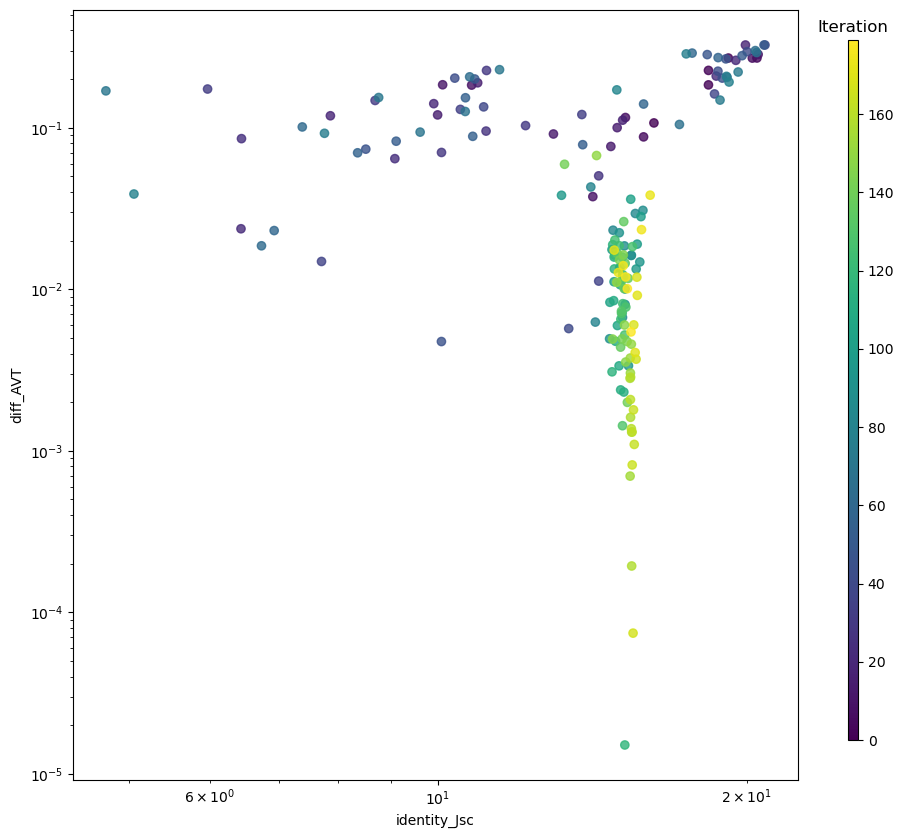

In [9]:
# Plot the Pareto front of the test problem
mo.plot_all_objectives(ax_client,logscale=True,figsize=(10,10))

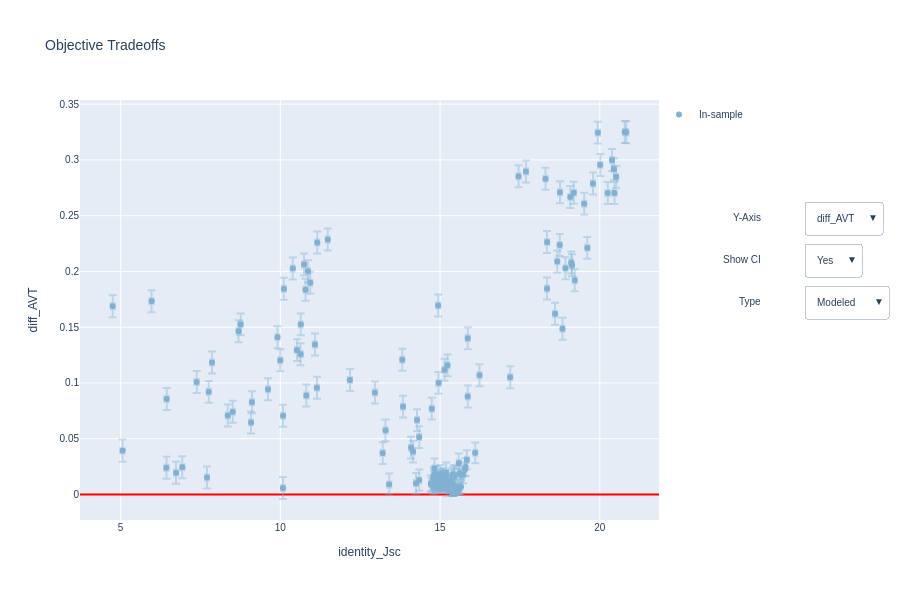

In [10]:
# Interactive plotting of the objective function tradeoffs
model = ax_client.generation_strategy.model
render(plot_objective_vs_constraints(model, 'identity_Jsc', rel=False))

[INFO 09-20 10:42:42] ax.service.ax_client: Retrieving contour plot with parameter 'd_3' on X-axis and 'd_4' on Y-axis, for metric 'identity_Jsc'. Remaining parameters are affixed to the middle of their range.


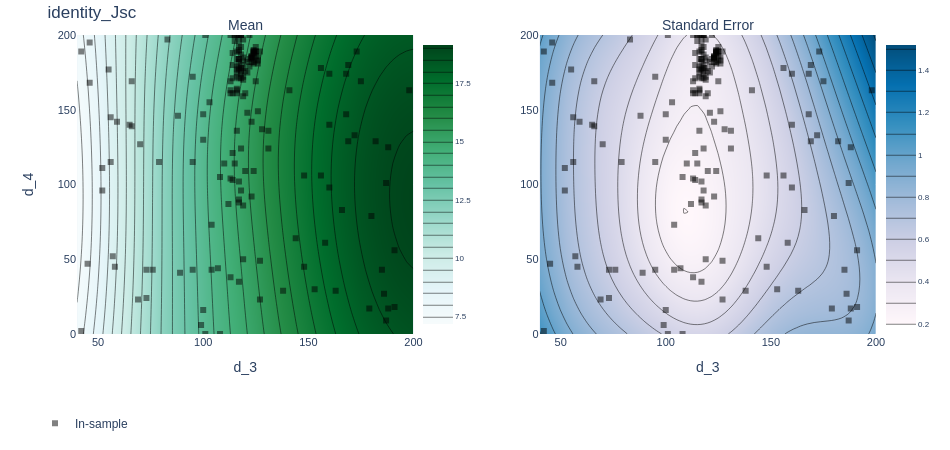

[INFO 09-20 10:42:44] ax.service.ax_client: Retrieving contour plot with parameter 'd_3' on X-axis and 'd_4' on Y-axis, for metric 'diff_AVT'. Remaining parameters are affixed to the middle of their range.


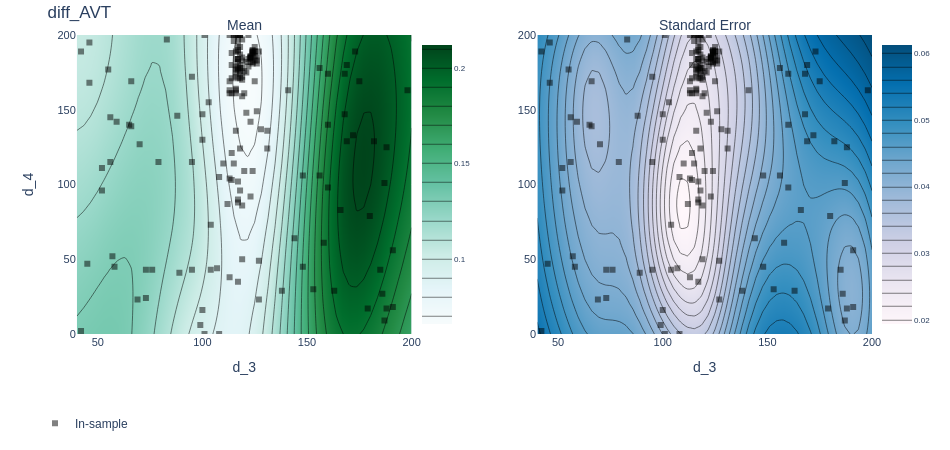

In [11]:
# Plot the contour of the objective function for a given target
render(ax_client.get_contour_plot(param_x="d_3", param_y="d_4", metric_name=obj_type+'_'+target['target_name']))
render(ax_client.get_contour_plot(param_x="d_3", param_y="d_4", metric_name=target2['obj_type']+'_'+target2['target_name']))

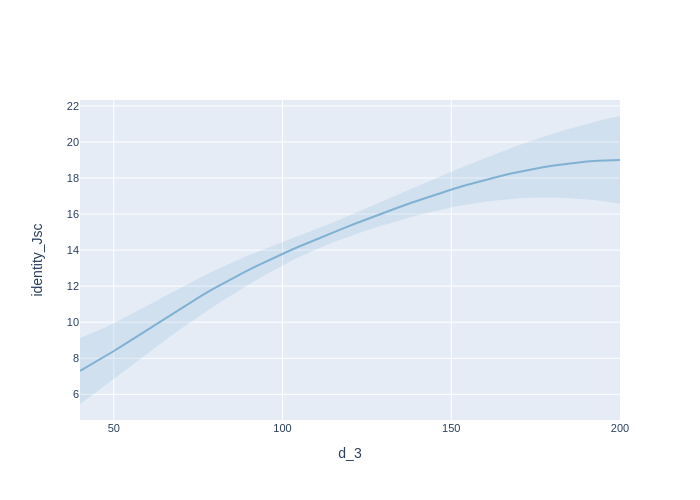

In [12]:
# Plot the slice (i.e., 1D projection) of the model along the a single dimension 
render(plot_slice(model, "d_3", obj_type+'_'+target['target_name']))

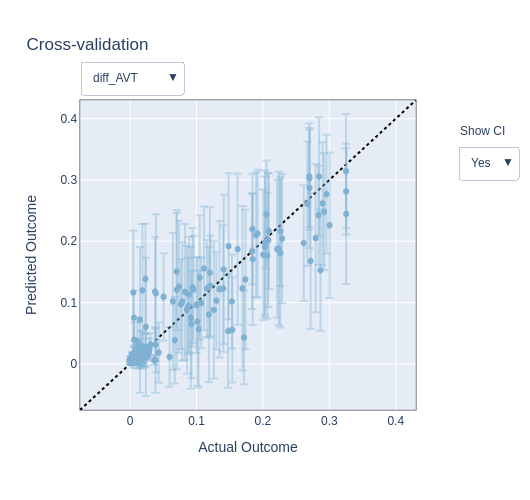

In [13]:
# Plot the results of cross validation
cv_results = cross_validate(model)
render(interact_cross_validation(cv_results))

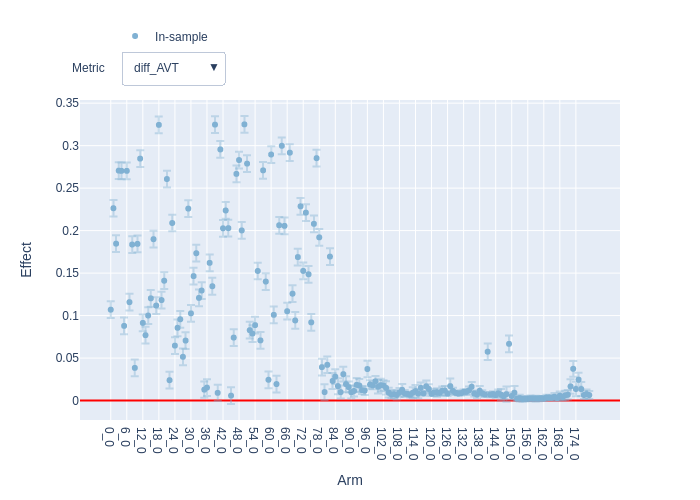

In [14]:
# Interactive plot of the target during the optimization process
render(interact_fitted(model, rel=False))

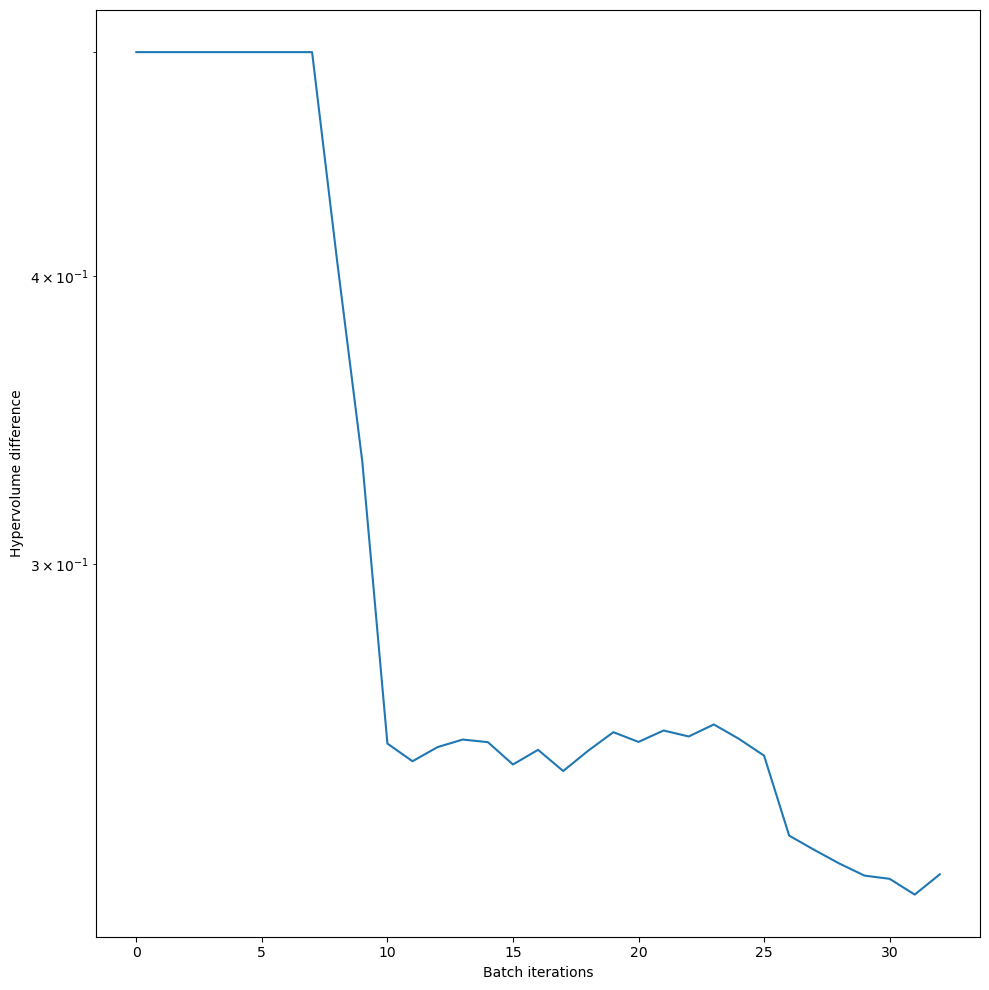

In [15]:
# Plot the hypervolume evolution during the optimization
mo.plot_hypervolume(logscale=True,figsize=(10,10))

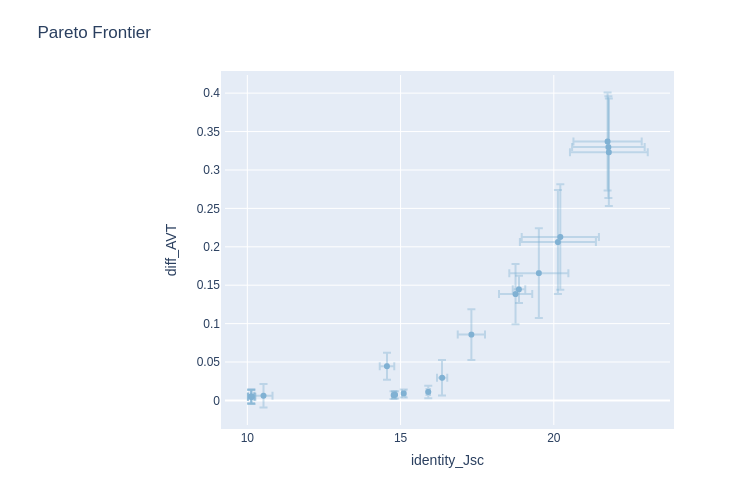

In [16]:
# Compute and plot the Pareto frontier
objectives = ax_client.experiment.optimization_config.objective.objectives
frontier = compute_posterior_pareto_frontier(
    experiment=ax_client.experiment,
    data=ax_client.experiment.fetch_data(),
    primary_objective=objectives[1].metric,
    secondary_objective=objectives[0].metric,
    absolute_metrics=["diff_AVT", "identity_Jsc"],
    num_points=20,
)
render(plot_pareto_frontier(frontier, CI_level=0.90)) 